# Detecção de Bordas com Threshold Inserindo Ruído Gaussiano Utilizando Limiar-Dilatacao v2

##### Módulos utilizados

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from copy import deepcopy

In [2]:
from imgaug import augmenters as iaa

## 1. Abrindo as imagens

In [3]:
folders = os.listdir('resultados-pre-processamento')
sub_folders = os.listdir('resultados-pre-processamento/'+folders[0])

imgs = {}
for key in folders:
    imgs[key] = {}
    for sub_key in sub_folders:
        imgs[key][sub_key] = []
        path = 'resultados-pre-processamento/'+key+'/'+sub_key
        for img in os.listdir(path):
            imgs[key][sub_key].append(cv2.imread(path+'/'+img))
            
imgs['sem'] = {}
for sub_key in sub_folders:
    imgs['sem'][sub_key] = []
    path = 'defeitos/'+sub_key
    for img in os.listdir(path):
        imgs['sem'][sub_key].append(cv2.imread(path+'/'+img))

## 2. Funções utilizadas

In [4]:
def preprocessing(img):
    # conversao da imagem para escala de cinza
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # aplicacao de filtro gaussiano
    imgblur = cv2.GaussianBlur(img_gray, (3,3), 0)
    # aplicacao de filtro laplaciano
    imglap = cv2.Laplacian(imgblur, cv2.CV_16S, ksize=3)
    # conversao para uint8
    imgabs = cv2.convertScaleAbs(imglap)
    # equalizacao de histograma
    imgeq = cv2.equalizeHist(imgabs)
    # filtro de media
    imgblur = cv2.blur(imgeq, (5,5))
    # limiarizacao binaria
    ret,thresh1 = cv2.threshold(imgblur,120,255,cv2.THRESH_BINARY_INV)
    # opening
    kernel = np.ones((13,13),np.uint8)
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    # dilatacao
    kernel_dl = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(opening,kernel_dl,iterations = 1)
    
    return dilation

In [5]:
def detect_threshold(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    output = deepcopy(img)
    jeans = cv2.blur(output, (13,13))
    _, jeans = cv2.threshold(jeans, 20, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(jeans, 50, 100)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for idx, contour in enumerate(contours):
        length = cv2.arcLength(contour, closed=True)
        if length < 260: continue

        x,y,w,h = cv2.boundingRect(contour)
        ellipse = cv2.fitEllipse(contour)
        cv2.putText(
            output, f'{int(length)}',
            (x+(w//2),y+(h//2)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, COLOR_GREEN, 5
        )
        cv2.ellipse(output, ellipse, COLOR_BLUE, 2)

    return output

In [6]:
COLOR_RED = (0, 0, 255)
COLOR_GREEN = (0, 255, 0)
COLOR_BLUE = (255, 0, 0)

In [15]:
def pipe_plot(prepross, folder):
    n = 16 # Definindo o número de plots
    fig = plt.figure(figsize=(15,20))
    #noise_model = iaa.AdditiveGaussianNoise(loc=1, scale=0.09*255)

    for i, img in zip(range(1,n,2),imgs[prepross][folder]):
        fig.add_subplot(4,2,i); plt.axis('off');
        plt.imshow(img, cmap='gray')

        fig.add_subplot(4,2,i+1); plt.axis('off');
        #a = cv2.Canny(img, 50, 100)
        #plt.imshow(noise_model.augment_image(a), cmap='gray')
        #img_noised = noise_model.augment_image(img)
        #plt.imshow(detect_threshold(img_noised), cmap='gray')
        img_pross = preprocessing(img)
        plt.imshow(detect_threshold(img_pross), cmap='gray')
        
        #plt.plot(cv2.calcHist(img,[0],None,[256],[0,256]))
        #plt.imshow(cv2.blur(img,(50,50)), cmap='gray')

## 3. Limiar-Dilatacao v2
### 3.1 Tecido 1

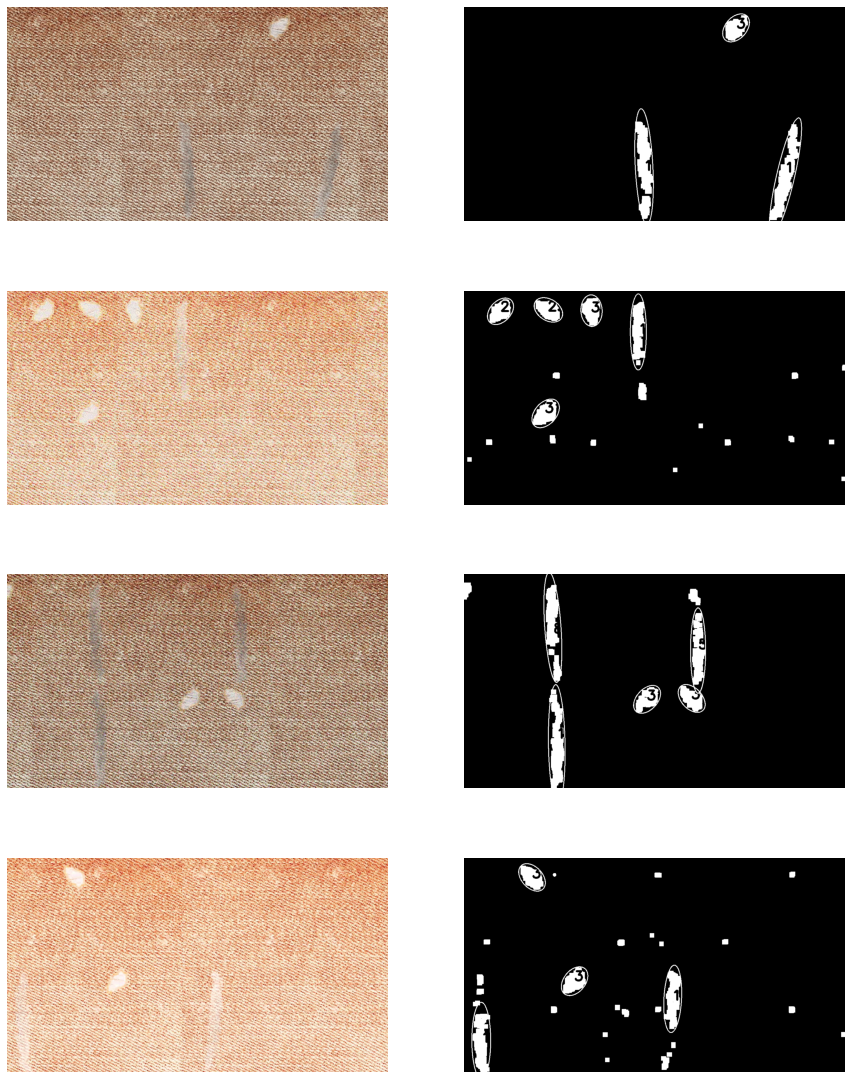

In [16]:
pipe_plot(prepross='sem', folder='tecido1')

### 4.3 Tecido 2

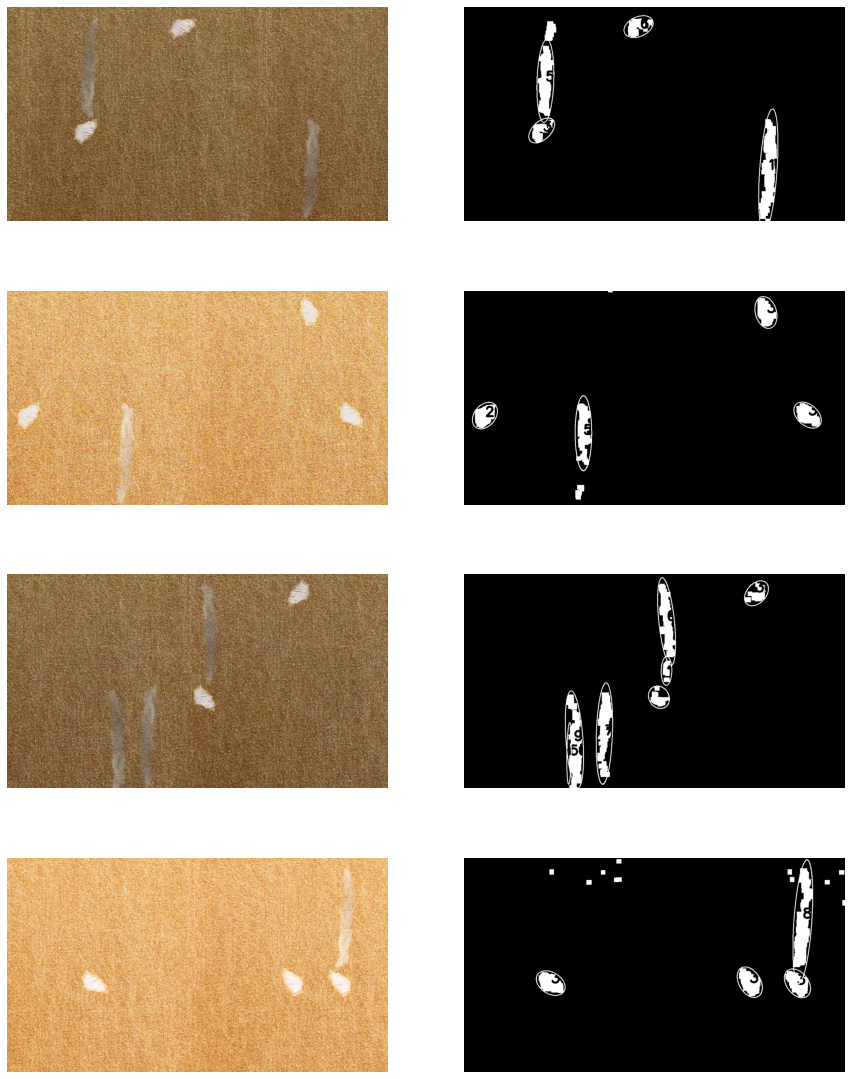

In [17]:
pipe_plot(prepross='sem', folder='tecido2')